In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os
import gzip
import struct
from tqdm.notebook import tqdm

In [45]:
# 设置随机种子以确保结果可复现
torch.manual_seed(42)
np.random.seed(42)

# 检查是否有可用的GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

# 定义Fashion-MNIST数据加载函数
def load_mnist(path, kind='train'):
    import os, gzip, numpy as np

    labels_path = os.path.join(path, f'{kind}-labels-idx1-ubyte.gz')
    images_path = os.path.join(path, f'{kind}-images-idx3-ubyte.gz')

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16)\
                  .reshape(len(labels), 28, 28)

    return images, labels



使用设备: cpu


In [46]:
# 加载训练集和测试集
data_dir = './data'

train_images, train_labels = load_mnist(data_dir, kind='train')
test_images, test_labels = load_mnist(data_dir, kind='t10k')


In [47]:
# 数据预处理
# 1. 归一化像素值到[0,1]
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0

# 2. 添加通道维度
train_images = train_images.reshape(-1, 1, 28, 28)
test_images = test_images.reshape(-1, 1, 28, 28)

# 3. 转换为PyTorch张量
X_train = torch.tensor(train_images)
y_train = torch.tensor(train_labels, dtype=torch.long)
X_test = torch.tensor(test_images)
y_test = torch.tensor(test_labels, dtype=torch.long)

# 创建数据加载器
batch_size = 64
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [48]:
# 定义类别名称
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 定义CNN模型
class FashionCNN(nn.Module):
    def __init__(self, dropout_rate=0.25):
        super(FashionCNN, self).__init__()
        # 第一个卷积块
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout2d(dropout_rate)
        
        # 第二个卷积块
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.dropout2 = nn.Dropout2d(dropout_rate)
        
        # 第三个卷积块
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.dropout3 = nn.Dropout2d(dropout_rate)
        
        # 全连接层
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.dropout4 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(256, 10)
    
    def forward(self, x):
        # 第一个卷积块
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # 第二个卷积块
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # 第三个卷积块
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = self.dropout3(x)
        
        # 展平
        x = x.view(x.size(0), -1)
        
        # 全连接层
        x = F.relu(self.fc1(x))
        x = self.dropout4(x)
        x = self.fc2(x)
        
        return x

In [49]:
# 定义超参数
learning_rate = 0.001
weight_decay = 1e-5  # L2正则化参数
num_epochs = 20

# 创建模型实例
model = FashionCNN().to(device)
print(model)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# 学习率调度器
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

# 早停策略
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        
    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

early_stopping = EarlyStopping(patience=5)

FashionCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout2d(p=0.25, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=1152, out_features=256, bias=True)
  (dropout4): Dropout(p=0.2

In [50]:
# 训练和评估函数
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # 梯度清零
        optimizer.zero_grad()
        
        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # 反向传播和优化
        loss.backward()
        optimizer.step()
        
        # 统计
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # 前向传播
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # 统计
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc, np.array(all_preds), np.array(all_labels)


In [51]:
# 训练模型
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs, device):
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    best_val_acc = 0.0
    best_model_weights = None
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # 训练一个epoch
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        
        # 验证
        val_loss, val_acc, _, _ = evaluate(model, test_loader, criterion, device)
        
        # 更新学习率
        scheduler.step(val_loss)
        
        # 记录历史
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        # 保存最佳模型
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_weights = model.state_dict().copy()
            print(f"保存新的最佳模型，验证准确率: {val_acc:.4f}")
            torch.save(model.state_dict(), 'results/best_fashion_mnist_model.pth')
        
        # 早停
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f"早停触发于epoch {epoch+1}")
            break
    
    # 加载最佳模型权重
    model.load_state_dict(best_model_weights)
    return model, history



Epoch 1/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.4968, Train Acc: 0.8176
Val Loss: 0.3299, Val Acc: 0.8768
保存新的最佳模型，验证准确率: 0.8768
Epoch 2/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.3366, Train Acc: 0.8763
Val Loss: 0.3040, Val Acc: 0.8917
保存新的最佳模型，验证准确率: 0.8917
Epoch 3/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.2984, Train Acc: 0.8909
Val Loss: 0.2755, Val Acc: 0.9002
保存新的最佳模型，验证准确率: 0.9002
Epoch 4/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.2771, Train Acc: 0.8971
Val Loss: 0.2517, Val Acc: 0.9073
保存新的最佳模型，验证准确率: 0.9073
Epoch 5/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.2595, Train Acc: 0.9037
Val Loss: 0.2442, Val Acc: 0.9107
保存新的最佳模型，验证准确率: 0.9107
Epoch 6/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.2440, Train Acc: 0.9103
Val Loss: 0.2347, Val Acc: 0.9136
保存新的最佳模型，验证准确率: 0.9136
Epoch 7/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.2346, Train Acc: 0.9131
Val Loss: 0.2363, Val Acc: 0.9157
保存新的最佳模型，验证准确率: 0.9157
Epoch 8/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.2267, Train Acc: 0.9161
Val Loss: 0.2236, Val Acc: 0.9180
保存新的最佳模型，验证准确率: 0.9180
Epoch 9/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.2179, Train Acc: 0.9193
Val Loss: 0.2191, Val Acc: 0.9191
保存新的最佳模型，验证准确率: 0.9191
Epoch 10/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.2104, Train Acc: 0.9216
Val Loss: 0.2336, Val Acc: 0.9159
Epoch 11/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.2068, Train Acc: 0.9226
Val Loss: 0.2143, Val Acc: 0.9215
保存新的最佳模型，验证准确率: 0.9215
Epoch 12/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.1970, Train Acc: 0.9266
Val Loss: 0.2306, Val Acc: 0.9211
Epoch 13/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.1946, Train Acc: 0.9266
Val Loss: 0.2163, Val Acc: 0.9227
保存新的最佳模型，验证准确率: 0.9227
Epoch 14/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.1903, Train Acc: 0.9285
Val Loss: 0.2147, Val Acc: 0.9254
保存新的最佳模型，验证准确率: 0.9254
Epoch 15/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.1707, Train Acc: 0.9361
Val Loss: 0.2049, Val Acc: 0.9279
保存新的最佳模型，验证准确率: 0.9279
Epoch 16/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.1632, Train Acc: 0.9384
Val Loss: 0.2060, Val Acc: 0.9293
保存新的最佳模型，验证准确率: 0.9293
Epoch 17/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.1601, Train Acc: 0.9400
Val Loss: 0.1983, Val Acc: 0.9312
保存新的最佳模型，验证准确率: 0.9312
Epoch 18/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.1539, Train Acc: 0.9421
Val Loss: 0.2074, Val Acc: 0.9293
Epoch 19/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.1514, Train Acc: 0.9435
Val Loss: 0.2092, Val Acc: 0.9284
Epoch 20/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.1474, Train Acc: 0.9439
Val Loss: 0.2020, Val Acc: 0.9311


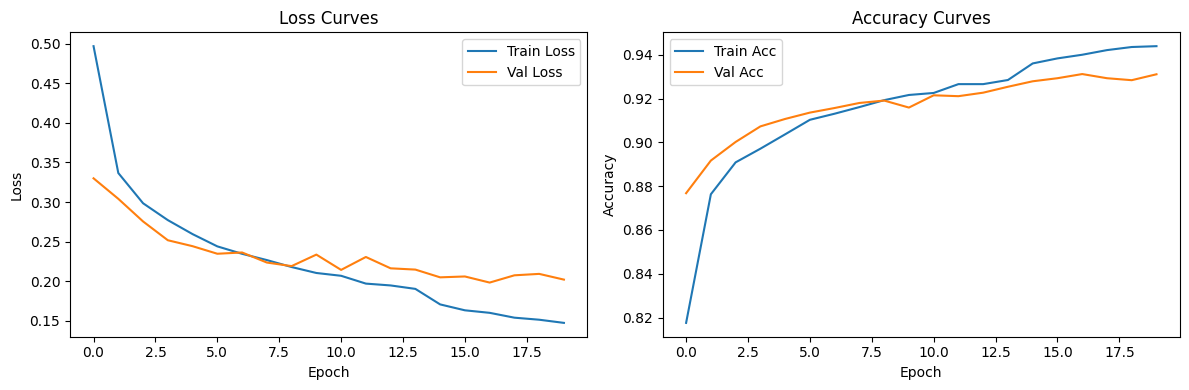

In [52]:
# 训练模型
model, history = train_model(
    model, 
    train_loader, 
    test_loader, 
    criterion, 
    optimizer, 
    scheduler, 
    num_epochs, 
    device
)

# 绘制训练过程
plt.figure(figsize=(12, 4))

# 绘制损失曲线
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

# 绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.tight_layout()
plt.savefig('results/training_curves.png')
plt.show()

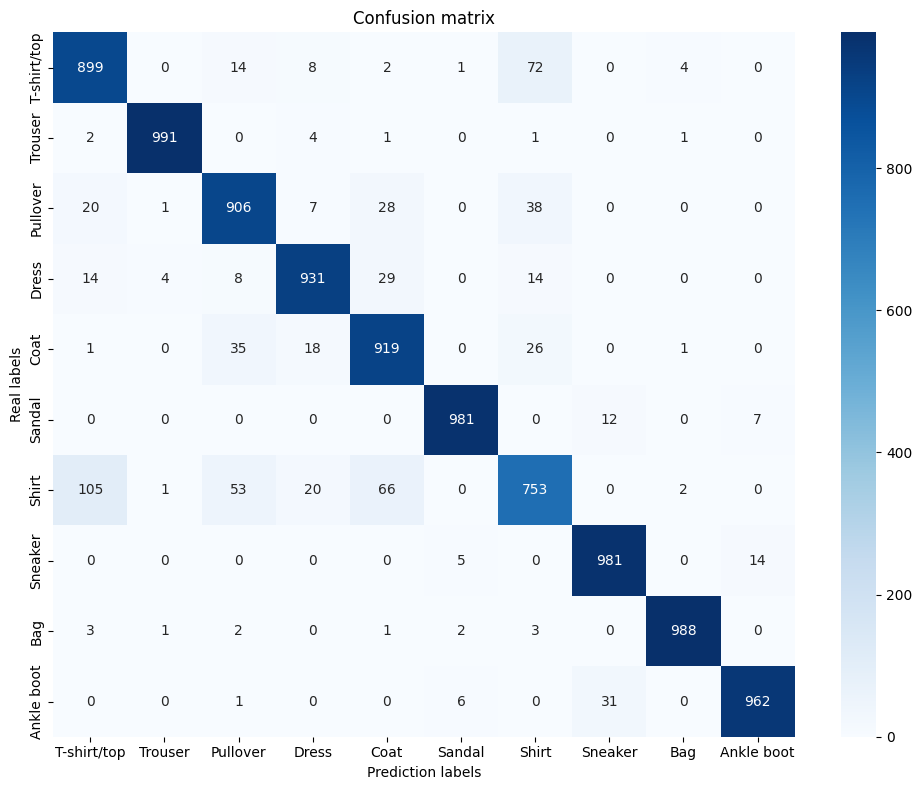

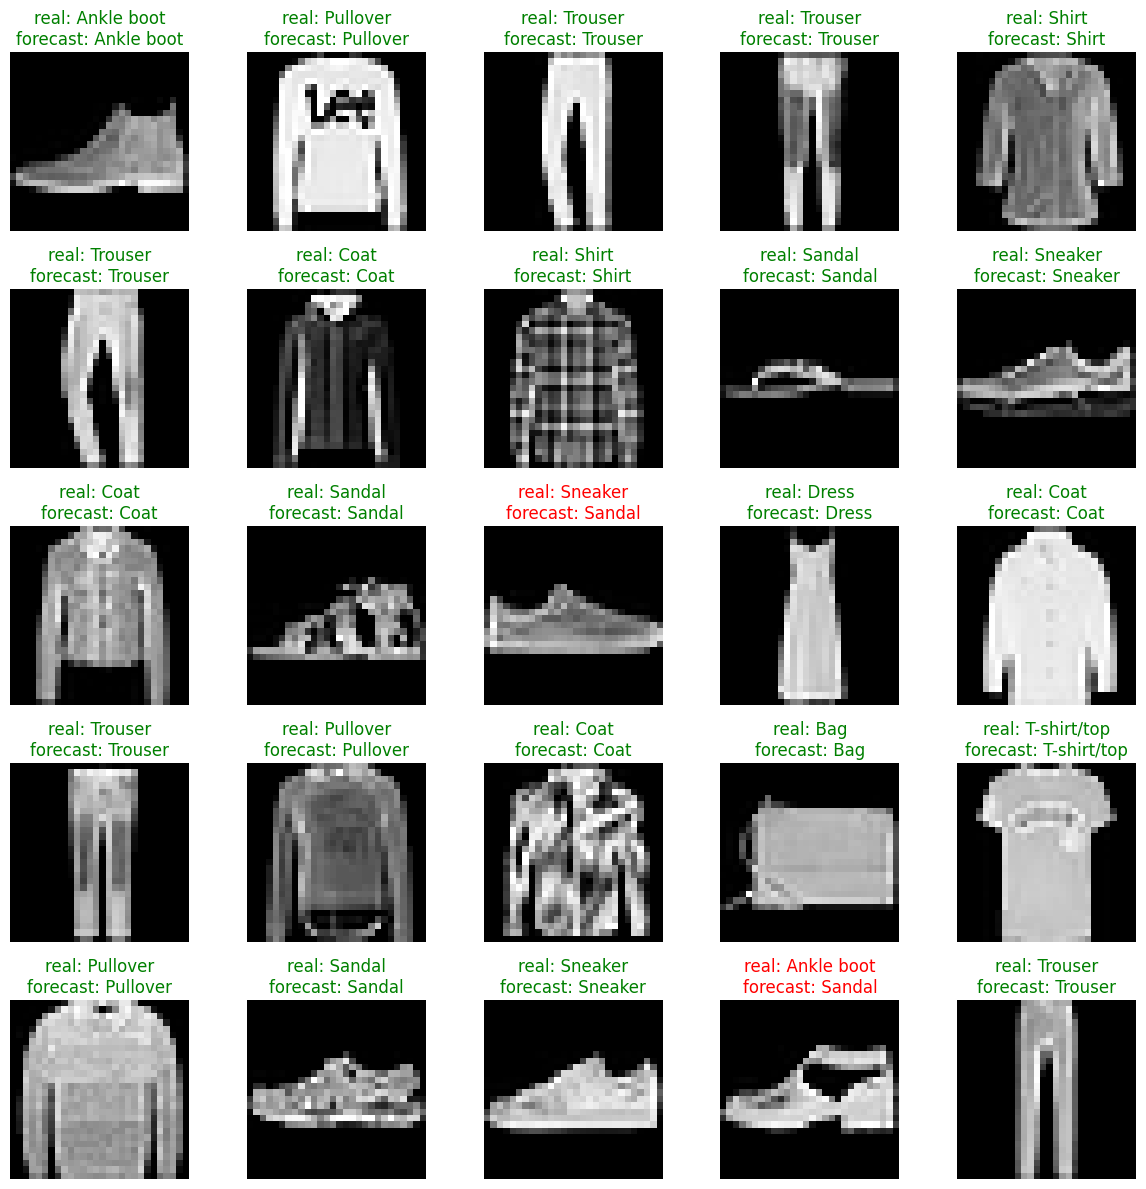

模型训练和评估完成！


In [53]:
# 收集真实标签和预测标签
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
# 计算并绘制混淆矩阵
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Prediction labels')
plt.ylabel('Real labels')
plt.title('Confusion matrix')
plt.tight_layout()
plt.savefig('results/confusion_matrix.png')
plt.show()
# 可视化一些预测结果
def visualize_predictions(model, test_loader, class_names, device, num_samples=25):
    model.eval()
    
    # 获取一批数据
    images, labels = next(iter(test_loader))
    images, labels = images[:num_samples], labels[:num_samples]
    
    # 获取预测
    with torch.no_grad():
        outputs = model(images.to(device))
        _, preds = torch.max(outputs, 1)
    
    # 绘制图像
    plt.figure(figsize=(12, 12))
    for i in range(num_samples):
        plt.subplot(5, 5, i+1)
        plt.imshow(images[i].squeeze().numpy(), cmap='gray')
        color = 'green' if preds[i] == labels[i] else 'red'
        plt.title(f"real: {class_names[labels[i]]}\nforecast: {class_names[preds[i]]}", color=color)
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('results/prediction_examples.png')
    plt.show()

visualize_predictions(model, test_loader, class_names, device)

# 保存整个模型
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'class_names': class_names
}, 'results/fashion_mnist_model_full.pth')

print("模型训练和评估完成！")